# A Watermark for Large Language Models

This is the Python notebook for our project. It generally follows the flow of the original paper, A Watermark for Large Language Models (Kirchenbauer et al. 2023). Much of the text and images in each section is pulled directly from the paper, though we have appended our own code to implement the paper's watermarking strategy and analysis.

In [1]:
# Install block - put any necessary pip installs here
!pip install datasets
!pip install torch

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (4.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 7.1 MB/s eta 0:00:00a 0:00:01
Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
Using cached MarkupSafe-3.0.2-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl (21 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [torch]32m5/6 [torch]kx]


In [64]:
# Import block - put any necessary imports here
from datasets import load_dataset, Dataset
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM, LogitsProcessor, LogitsProcessorList
from functools import partial
import json
import math
import matplotlib.pyplot as plt
import numpy as np

# Set up device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(F"Device set to {device}")

Device set to cpu


# Load the Dataset

The paper uses the C4 dataset’s RealNewsLike subset

In [5]:
dataset_name = "c4"
dataset_config_name = "realnewslike"
dataset = load_dataset(dataset_name, dataset_config_name, split="train", streaming=True)

/home/berkgokmen/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d2c4b4bba37cb7092cdd83083d5ec11207db/c4.py:53: FutureWarning: Dataset 'c4' is deprecated and will be deleted. Use 'allenai/c4' instead.
  warnings.warn(


# Load the Opt-1.3b tokenizer and model

In [6]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

# Load the model
model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m")
model = model.to(device)

# Helpers
def tokenize(sequence):
    return tokenizer(sequence, return_tensors="pt").to(model.device)

def seed_rng(seed=42):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

# Algorithm 1: Text Generation with Hard Red List

![images/algorithm_1.png](images/algorithm_1.png)

## Define the Hard Red List Logits Processor

In [54]:
class HardRedListWatermark(LogitsProcessor):

    def __init__(self, tokenizer, device, gamma=0.5, hash_key=15485863):
        self.tokenizer = tokenizer
        self.device = device
        self.vocab_size = tokenizer.vocab_size
        self.green_list_size = int(self.vocab_size * gamma)
        # Large prime number to be used for seed
        self.hash_key = hash_key
        self.generator = torch.Generator(device=device)

    def __call__(self, input_ids, scores):
        # Compute hash of previous token and set it as seed
        prev_token = int(input_ids[0, -1].item())
        self.generator.manual_seed(self.hash_key * prev_token)

        # Shuffle the vocabulary and get red list ids
        permuted_vocab = torch.randperm(self.vocab_size, generator=self.generator, device=input_ids.device)
        red_list = permuted_vocab[self.green_list_size:] # continue where green list left off

        # Set red list logits to -infinity
        scores[:, red_list] = -float("inf")
        return scores

    def compute_green_and_red_lists(self):
        permuted_vocab = torch.randperm(self.vocab_size, generator=self.generator, device=self.device)
        green_list = permuted_vocab[:self.green_list_size]
        red_list = permuted_vocab[self.green_list_size:]

        return green_list, red_list

    def produce_color_map(self, prompt_ids, generated_token_ids):
        # Set seed for reproducibility
        seed_rng()

        # Get last prompt_id
        prev_token_id = int(prompt_ids['input_ids'][0, -1].item())

        color_map = []

        for i, token_id in enumerate(generated_token_ids['input_ids'][0]):
            token_id = int(token_id.item())
            self.generator.manual_seed(self.hash_key * prev_token_id)

            green_list, _ = self.compute_green_and_red_lists()

            if token_id in green_list:
                color_map.append(1) # green
            else:
                color_map.append(0) # red

            # Update previous token before next iteration
            prev_token_id = token_id

        return color_map

## Implement Algorithm 1 using Hard Red List Logits Processor

In [55]:
def algorithm_1(model, prompt_ids, gamma=0.5):

    hard_watermark = HardRedListWatermark(tokenizer, model.device, gamma)

    # Set seed for reproducibility
    seed_rng()

    # Instantiate the hard red list logits processor
    hard_red_list_lp = LogitsProcessorList([hard_watermark])

    # Generate using the hard red list logits processor
    algorithm_1_generate = partial(
        model.generate,
        logits_processor=hard_red_list_lp,
        max_new_tokens=200,
        min_new_tokens=1,
        do_sample=True,
        top_k=0,
        temperature=0.7
    )

    # Generate output ids
    output_ids = algorithm_1_generate(**prompt_ids)

    # Return output ids
    return hard_watermark, output_ids

## Running Algorithm 1

In [56]:
# Helpers

def compute_z_score(green_token_count, total_length, gamma):
    numerator = green_token_count - (gamma * total_length)
    denominator = math.sqrt(total_length * gamma * (1 - gamma))
    return numerator / denominator

In [66]:
results = []
def run_hard_watermark(results, gamma=0.5):
  for i, prompts in enumerate(dataset):
    prompt = prompts["text"]
    # Tokenize prompt into ids
    prompt_ids = tokenize(prompt)
    prompt_ids_size = prompt_ids["input_ids"].size(-1)
    # Generate outputs
    hard_watermark, output_ids = algorithm_1(model, prompt_ids)
    generated_token_ids = {"input_ids": output_ids[:, prompt_ids_size:]}

    # Given a continuation, compute which tokens are in the red list and which are in the green list
    color_map = hard_watermark.produce_color_map(
      prompt_ids = prompt_ids,
      generated_token_ids = generated_token_ids,
    )
    continuation_token_count = len(generated_token_ids['input_ids'][0])
    green_token_count = len(list(filter(lambda x: x, color_map)))
    
    # Decode ids to strings
    continuation = tokenizer.decode(generated_token_ids["input_ids"][0], skip_special_tokens=True)
    output = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Collect results
    result_dict = {
      "prompt": prompt,
      "continuation": continuation,
      "full_output": output,
      "continuation_token_count": continuation_token_count,
      "green_token_count": green_token_count,
      "z_score": compute_z_score(green_token_count, continuation_token_count, gamma),
      "color_map": color_map
    }
    results.append(result_dict)
    # print(json.dumps(result_dict, indent=1))

    # For now just break after generating 1 result since it takes a while
    if i >= 0:
        break
    
run_hard_watermark(results, gamma=0.1)

## z-Score vs. Sequence Length for Algorithm 1

In [68]:
# Define colors to match paper colors
colors = ["#76c04b", "#35978f", "#1f78b4", "#5e3c99", "#8c510a"]
# gammas = [0.1, 0.25, 0.5, 0.75, 0.9]

gammas = [0.5]
delta = 5.0
max_seq_length = 200

/home/berkgokmen/miniforge3/envs/watermark/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/berkgokmen/miniforge3/envs/watermark/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


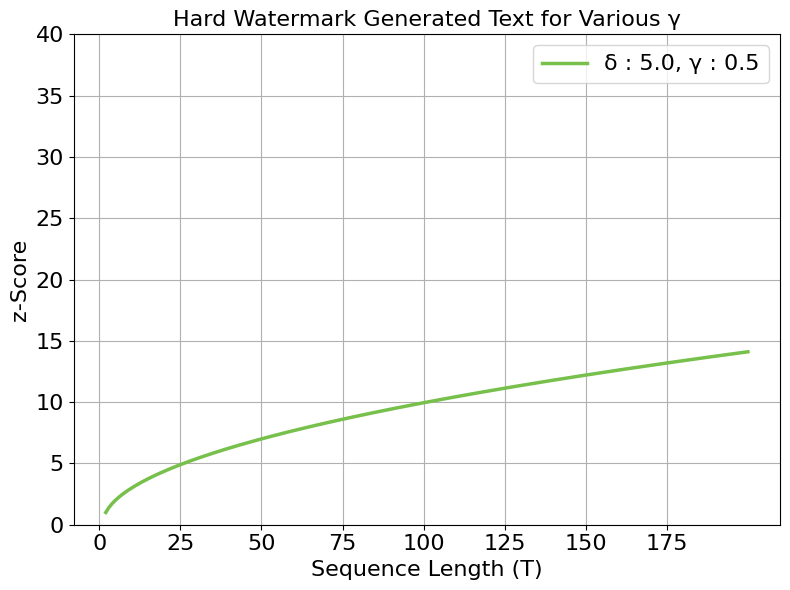

In [ ]:
seq_lengths = np.arange(1, max_seq_length+1)

plt.figure(figsize=(8, 6))

for i, gamma in enumerate(gammas):
    z_scores = [[] for _ in range(max_seq_length)]
    z_scores[0] = [0]
    hard_watermark_results = []

    run_hard_watermark(hard_watermark_results, gamma)

    for result in hard_watermark_results:
        for j in range(1, result["continuation_token_count"]):
            green_count = len(list(filter(lambda x: x, result["color_map"][:j])))
            z_score = compute_z_score(green_count, j, gamma)
            z_scores[j].append(z_score)
            
    avg_z_scores = [np.mean(z_scores[k]) for k in range(max_seq_length)]

    plt.plot(seq_lengths, avg_z_scores,
             label=f'δ : {delta}, γ : {gamma}',
             linewidth=2.5,
             color=colors[i])

# Formatting to match paper
plt.xlabel('Sequence Length (T)', fontsize=16)
plt.ylabel('z‑Score', fontsize=16)
plt.title('Hard Watermark Generated Text for Various γ', fontsize=16)
plt.grid(True)
plt.legend(fontsize=16)
plt.xticks(np.arange(0, 200, 25), fontsize=16)
plt.yticks(np.arange(0, 45, 5), fontsize=16)
plt.tight_layout()
plt.show()

# Algorithm 2: Text Generation with Soft Red List

![images/algorithm_2.png](images/algorithm_2.png)

## Define the Soft Red List Logits Processor

In [ ]:
class SoftRedListWatermark(LogitsProcessor):
    def __init__(self, tokenizer, device, gamma=0.5, hash_key=15485863, delta=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.device = device
        self.vocab_size = tokenizer.vocab_size
        self.gamma = gamma
        self.hash_key = hash_key
        self.delta = delta
        self.green_list_size = int(self.gamma * self.vocab_size)
        self.generator = torch.Generator(device=device)

        # Entropy metrics
        self.spike_entropies = []
        self.z_parameter = (1 - gamma) * (math.exp(delta) - 1) / (1 + (math.exp(delta) - 1) * gamma)

    def __call__(self, input_ids, scores):
        # Get raw probabilities before watermarking
        raw_probs = torch.softmax(scores, dim=-1)

        # Compute spike entropy of the raw distribution
        entropy = self.compute_spike_entropy(raw_probs, self.z_parameter)
        self.spike_entropies.append(entropy.item())

        # Compute hash of previous token and set it as seed
        prev_token = int(input_ids[0, -1].item())
        self.generator.manual_seed(self.hash_key * prev_token)

        # Shuffle the vocabulary and get green list ids
        permuted_vocab = torch.randperm(self.vocab_size, generator=self.generator, device=input_ids.device)
        green_list = permuted_vocab[:self.green_list_size]

        # Add delta to green list logits
        scores[:, green_list] += self.delta
        return scores

    def compute_spike_entropy(self, p, z):
        """Calculate spike entropy of probability vector p with modulus z."""
        denom = 1.0 + z * p
        denom = torch.clamp(denom, min=1e-9)
        return torch.sum(p / denom)

    def get_average_spike_entropy(self):
        """Calculate the average spike entropy over the generated sequence."""
        if not self.spike_entropies:
            return 0.0
        return sum(self.spike_entropies) / len(self.spike_entropies)

    def reset_metrics(self):
        """Reset the spike entropy measurements for a new generation."""
        self.spike_entropies = []

    def compute_green_and_red_lists(self):
        permuted_vocab = torch.randperm(self.vocab_size, generator=self.generator, device=self.device)
        green_list = permuted_vocab[:self.green_list_size]
        red_list = permuted_vocab[self.green_list_size:]

        return green_list, red_list

    def produce_color_map(self, prompt_ids, generated_token_ids):
        # Set seed for reproducibility
        seed_rng()

        # Get last prompt_id
        prev_token_id = int(prompt_ids['input_ids'][0, -1].item())

        color_map = []

        for i, token_id in enumerate(generated_token_ids['input_ids'][0]):
            token_id = int(token_id.item())
            self.generator.manual_seed(self.hash_key * prev_token_id)

            green_list, _ = self.compute_green_and_red_lists()

            if token_id in green_list:
                color_map.append(1) # green
            else:
                color_map.append(0) # red

            # Update previous token before next iteration
            prev_token_id = token_id

        return color_map

## Implement Algorithm 2 using Soft Red List Logits Processor

In [ ]:
delta = 2.0
gamma = 0.5

soft_watermark = SoftRedListWatermark(tokenizer, model.device)

def algorithm_2(tokenizer, model, prompt_ids):
    # Set seed for reproducibility
    seed_rng()

    # Generate without watermark
    output_no_watermark = model.generate(
        **prompt_ids,
        max_new_tokens=200,
        min_new_tokens=1,
        do_sample=True,
        temperature=0.7
    )
    text_no_watermark = tokenizer.decode(output_no_watermark[0], skip_special_tokens=True)[len(prompt):]

    # Generate using the soft red list logits processor
    output_watermarked = model.generate(
        **prompt_ids,
        logits_processor=LogitsProcessorList([soft_watermark]),
        max_new_tokens=200,
        min_new_tokens=1,
        do_sample=True,
        temperature=0.7
    )
    text_watermarked = tokenizer.decode(output_watermarked[0], skip_special_tokens=True)[len(prompt):]

    # Get the average spike entropy during generation
    avg_entropy = soft_watermark.get_average_spike_entropy()
    # Reset metrics
    soft_watermark.reset_metrics()

    # Decode and return the text and entropy
    return {
        "non_watermarked": {
            "continuation": text_no_watermark,
        },
        "watermarked": {
            "continuation": text_watermarked,
            "avg_entropy": avg_entropy,
        }
    }

## Running Algorithm 2

In [ ]:
# Helpers

def compute_perplexity(model, tokenizer, text):
    # Tokenize text
    encodings = tokenizer(text, return_tensors="pt").to(model.device)

    # Get sequence length
    seq_len = encodings.input_ids.size(1)

    # Use the entire sequence as both input and target
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    # Calculate loss
    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        neg_log_likelihood = outputs.loss * seq_len

    # Calculate perplexity
    ppl = torch.exp(neg_log_likelihood / seq_len)
    return ppl.item()

def compute_z_score(green_token_count, total_length, gamma):
    numerator = green_token_count - (gamma * total_length)
    denominator = math.sqrt(total_length * gamma * (1 - gamma))
    return numerator / denominator

def print_colored_terminal(text, color_map, tokenizer):
    tokens = tokenizer.encode(text, add_special_tokens=False)
    token_texts = [tokenizer.decode([token]) for token in tokens]

    for i, token_text in enumerate(token_texts):
        if i < len(color_map):
            if color_map[i] == 1:
                # Green text in terminal
                print(f"\033[92m{token_text}\033[0m", end="")
            else:
                # Red text in terminal
                print(f"\033[91m{token_text}\033[0m", end="")
        else:
            print(token_text, end="")
    print()

In [ ]:
results = []
for i, prompts in enumerate(dataset):
  prompt = prompts["text"]
  result_dict = {
    "prompt": prompt,
  }
  # Tokenize prompt into ids
  prompt_ids = tokenize(prompt)
  # Generate output
  result_dict.update(
    algorithm_2(tokenizer, model, prompt_ids)
  )

  # Given a continuation, compute which tokens are in the red list and which are in the green list
  generated_token_ids = tokenize(result_dict["watermarked"]["continuation"])
  color_map = soft_watermark.produce_color_map(
    prompt_ids = prompt_ids,
    generated_token_ids = generated_token_ids,
  )
  continuation_token_count = len(generated_token_ids['input_ids'][0])
  green_token_count = len(list(filter(lambda x: x, color_map)))

  # Collect results
  result_dict["watermarked"] = {
    "continuation": result_dict["watermarked"]["continuation"],
    # "color_map": color_map,
    "continuation_token_count": continuation_token_count,
    "green_token_count": green_token_count,
    "avg_entropy": result_dict["watermarked"]["avg_entropy"],
    "z_score": compute_z_score(green_token_count, continuation_token_count, gamma),
    "PPL": compute_perplexity(model, tokenizer, result_dict["watermarked"]["continuation"])
  }
  result_dict["non_watermarked"].update(
    {
      "PPL": compute_perplexity(model, tokenizer, result_dict["non_watermarked"]["continuation"])
    }
  )
  results.append(result_dict)
  print(json.dumps(result_dict, indent=1))

  # For now just break after generating 1 result since it takes a while
  if i >= 0:
      break

# Add this line to print colored text in terminal
# print("\nColored continuation:")
# print_colored_terminal(continuation, color_map, tokenizer)

# Algorithm 3: Robust Private Watermarking

![images/algorithm_3.png](images/algorithm_3.png)

In [ ]:
# This is the code block for Algorithm 3

def algorithm_3():
    # TODO: Implement Algorithm 3
    raise NotImplementedError()